# PQMass Distribution Analysis

This notebook evaluates whether BIND-generated halos come from the same underlying distribution as the true hydrodynamic halos using the **Probabilistic Quality Assessment using Probability Mass Estimation (PQMass)** method.

## Overview

PQMass (Lemos et al. 2024, ICLR 2025) is a sample-based method for comparing two distributions. It works by:

1. Creating Voronoi tessellations using reference points drawn from both distributions
2. Counting how many samples from each distribution fall into each Voronoi cell
3. Performing a chi-squared test on the multinomial counts

$$\chi^2_{PQM} = \sum_{i=1}^{n_R} \left[ \frac{(k(x, R_i) - \hat{N}_{x,i})^2}{\hat{N}_{x,i}} + \frac{(k(y, R_i) - \hat{N}_{y,i})^2}{\hat{N}_{y,i}} \right]$$

### Interpretation:
- **p-value ~ 0.5 ± 0.26**: Samples come from the same distribution (uniform distribution under null)
- **p-value << 0.05**: Reject null hypothesis - distributions are different
- **χ²/DoF ~ 1**: Same distribution (DoF = num_refs - 1)
- **χ²/DoF >> 1**: Out of distribution

## Paper Reference
- [PQMass: Probabilistic Assessment of the Quality of Generative Models using Probability Mass Estimation](https://arxiv.org/abs/2402.04355)
- GitHub: https://github.com/Ciela-Institute/PQM

## 1. Setup & Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2 as chi2_dist
import pandas as pd
import glob
from tqdm import tqdm
import torch

# PQM library
from pqm import pqm_pvalue, pqm_chi2

# Local utilities
import sys
sys.path.insert(0, '..')
from paper_notebooks.paper_utils import (
    setup_plotting_style, BOX_SIZE, GRID_SIZE, PIXEL_TO_MPC, MODEL_NAME,
    CHANNEL_NAMES, CHANNEL_LABELS, load_1p_params, load_sb35_metadata, savefig_paper
)

setup_plotting_style()

import os
os.makedirs('paper_plots', exist_ok=True)

# Channel configuration
CHANNEL_NAMES_PQM = ['DM', 'Gas', 'Stars', 'Total']
CHANNEL_COLORS = {'DM': 'purple', 'Gas': 'blue', 'Stars': 'orange', 'Total': 'green'}

## 2. Data Loading Functions

In [ ]:
def load_all_halos(dataset, sim_list, n_pixels_subsample=100, verbose=True):
    """
    Load all halos from a dataset and flatten them for PQM analysis.
    
    Each halo becomes a sample, with subsampled pixels as features.
    
    Parameters
    ----------
    dataset : str
        Dataset name ('CV', '1P', 'SB35')
    sim_list : list
        List of simulation IDs to load
    n_pixels_subsample : int
        Number of pixels to subsample per halo (feature dimension)
        
    Returns
    -------
    dict : Dictionary with 'true' and 'generated' arrays for each channel
           Shape: (n_halos, n_pixels_subsample) for true
                  (n_halos * n_realizations, n_pixels_subsample) for generated
    """
    # Fix pixel indices for consistent comparison across halos
    np.random.seed(42)
    pixel_indices = np.random.choice(128 * 128, size=n_pixels_subsample, replace=False)
    
    # Storage for each channel
    true_halos = {ch: [] for ch in CHANNEL_NAMES_PQM}
    gen_halos = {ch: [] for ch in CHANNEL_NAMES_PQM}
    halo_metadata = {'masses': [], 'radii': [], 'sim_ids': []}
    
    # Track skipped halos
    n_skipped_nan = 0
    n_skipped_negative = 0
    
    iterator = tqdm(sim_list, desc=f'Loading {dataset}') if verbose else sim_list
    
    for sim_id in iterator:
        try:
            # Construct path based on dataset
            if dataset == 'CV':
                basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/CV/sim_{sim_id}/snap_90/mass_threshold_13/'
            elif dataset == '1P':
                basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/1P/sim_{sim_id}/snap_90/mass_threshold_13/'
            elif dataset == 'SB35':
                basepath = f'/mnt/home/mlee1/ceph/BIND2d_new/SB35/sim_{sim_id}/snap_90/mass_threshold_13/'
            else:
                raise ValueError(f"Unknown dataset: {dataset}")
            
            # Load data
            hydro_cutouts = np.load(basepath + 'hydro_cutouts.npy')  # (n_halos, 3, 128, 128)
            meta = np.load(basepath + 'halo_metadata.npz', allow_pickle=True)
            
            gen_data = np.load(basepath + f'{MODEL_NAME}/generated_halos.npz')
            gen_cutouts = gen_data['generated']  # (n_halos, n_realizations, 3, 128, 128)
            
            n_halos_sim = len(hydro_cutouts)
            n_realizations = gen_cutouts.shape[1]
            
            for halo_idx in range(n_halos_sim):
                # =============================================================
                # Validate halo data before adding
                # =============================================================
                hydro_halo = hydro_cutouts[halo_idx]  # (3, 128, 128)
                gen_halo = gen_cutouts[halo_idx]  # (n_realizations, 3, 128, 128)
                
                # Check for NaN/Inf in hydro
                if not np.all(np.isfinite(hydro_halo)):
                    n_skipped_nan += 1
                    continue
                
                # Check for NaN/Inf in generated
                if not np.all(np.isfinite(gen_halo)):
                    n_skipped_nan += 1
                    continue
                
                # Check for negative values (can cause issues with log transform)
                # if np.any(hydro_halo < 0) or np.any(gen_halo < 0):
                #     n_skipped_negative += 1
                #     continue
                
                # Process each channel
                for ch_idx, ch_name in enumerate(CHANNEL_NAMES_PQM[:3]):  # DM, Gas, Stars
                    # True halo: flatten and subsample pixels
                    true_map = hydro_halo[ch_idx].flatten()[pixel_indices]
                    true_halos[ch_name].append(true_map)
                    
                    # Generated halos: all realizations
                    for real_idx in range(n_realizations):
                        gen_map = gen_halo[real_idx, ch_idx].flatten()[pixel_indices]
                        gen_halos[ch_name].append(gen_map)
                
                # Total (sum of channels)
                true_total = hydro_halo.sum(axis=0).flatten()[pixel_indices]
                true_halos['Total'].append(true_total)
                
                for real_idx in range(n_realizations):
                    gen_total = gen_halo[real_idx].sum(axis=0).flatten()[pixel_indices]
                    gen_halos['Total'].append(gen_total)
                
                # Metadata
                halo_metadata['masses'].append(meta['masses'][halo_idx] if 'masses' in meta else 0)
                halo_metadata['radii'].append(meta['radii'][halo_idx] if 'radii' in meta else 0)
                halo_metadata['sim_ids'].append(sim_id)
                
        except Exception as e:
            if verbose:
                print(f"Error loading {dataset} sim {sim_id}: {e}")
            continue
    
    # Report skipped halos
    if n_skipped_nan > 0 or n_skipped_negative > 0:
        print(f"  Skipped {n_skipped_nan} halos with NaN/Inf, {n_skipped_negative} with negative values")
    
    # Convert to arrays
    for ch in CHANNEL_NAMES_PQM:
        true_halos[ch] = np.array(true_halos[ch], dtype=np.float32)
        gen_halos[ch] = np.array(gen_halos[ch], dtype=np.float32)
    
    for key in halo_metadata:
        halo_metadata[key] = np.array(halo_metadata[key])
    
    return {'true': true_halos, 'generated': gen_halos, 'metadata': halo_metadata}

## 3. Load All Datasets

In [3]:
# Load metadata for simulation lists
sb35_metadata, sb35_minmax, sb35_sim_nums = load_sb35_metadata()
oneP_params, names_1p, param_array_1p, fiducial_params = load_1p_params()
cv_sims = [i for i in range(27) if i != 17]  # CV sims excluding 17

print(f"CV simulations: {len(cv_sims)}")
print(f"1P simulations: {len(names_1p)}")
print(f"SB35 simulations: {len(sb35_sim_nums)}")

CV simulations: 26
1P simulations: 140
SB35 simulations: 58


In [4]:
# DEBUG: Check if file paths exist
import os

# Test one path from each dataset
test_paths = [
    '/mnt/home/mlee1/ceph/BIND2d_new/CV/sim_0/snap_90/mass_threshold_13/',
    '/mnt/home/mlee1/ceph/BIND2d_new/1P/sim_1P_p0_0/snap_90/mass_threshold_13/',
    '/mnt/home/mlee1/ceph/BIND2d_new/SB35/sim_0/snap_90/mass_threshold_13/',
]

print("Checking data paths...")
for path in test_paths:
    exists = os.path.exists(path)
    print(f"  {path}: {'✓ EXISTS' if exists else '✗ NOT FOUND'}")
    if exists:
        files = os.listdir(path)
        print(f"    Files: {files[:5]}...")  # Show first 5 files

# Check what simulation IDs look like
print(f"\nCV sims: {cv_sims[:5]}...")
print(f"1P names: {names_1p[:5]}...")
print(f"SB35 nums: {sb35_sim_nums[:5]}...")

Checking data paths...
  /mnt/home/mlee1/ceph/BIND2d_new/CV/sim_0/snap_90/mass_threshold_13/: ✓ EXISTS
    Files: ['dmo2hydro_omnormalized', 'clean_vdm_cross_attention_quantile', 'dmo2hydro_1024_multi_fourier', 'nocosmo', 'dmo2hydro_noparam_pred']...
  /mnt/home/mlee1/ceph/BIND2d_new/1P/sim_1P_p0_0/snap_90/mass_threshold_13/: ✗ NOT FOUND
  /mnt/home/mlee1/ceph/BIND2d_new/SB35/sim_0/snap_90/mass_threshold_13/: ✗ NOT FOUND

CV sims: [0, 1, 2, 3, 4]...
1P names: ['1P_p1_n2', '1P_p1_n1', '1P_p1_1', '1P_p1_2', '1P_p2_n2']...
SB35 nums: [5, 11, 14, 31, 56]...


In [5]:
# Load all halos from each dataset
# N_PIXELS controls the feature dimensionality:
#   - More pixels = higher dimensional comparison (more information, but slower)
#   - Fewer pixels = lower dimensional (faster, but may miss details)
#   - PQM works well up to ~100-500 dimensions
#   - 100 pixels captures ~0.6% of each halo (128x128 = 16,384 total pixels)
#   - The SAME random pixels are used for all halos (consistent comparison)

N_PIXELS = 1000  # Can try: 50, 100, 200, 500, 1000

print(f"Using N_PIXELS = {N_PIXELS} ({100*N_PIXELS/16384:.1f}% of each halo)")
print("="*60)

print("\nLoading CV halos...")
cv_data = load_all_halos('CV', cv_sims, n_pixels_subsample=N_PIXELS)

print("\nLoading 1P halos...")
oneP_data = load_all_halos('1P', names_1p, n_pixels_subsample=N_PIXELS)

print("\nLoading SB35 halos...")
sb35_data = load_all_halos('SB35', sb35_sim_nums, n_pixels_subsample=N_PIXELS)

Using N_PIXELS = 1000 (6.1% of each halo)

Loading CV halos...


Loading CV:   0%|          | 0/26 [00:00<?, ?it/s]

Loading CV: 100%|██████████| 26/26 [00:25<00:00,  1.04it/s]



Error loading CV sim 25: [Errno 2] No such file or directory: '/mnt/home/mlee1/ceph/BIND2d_new/CV/sim_25/snap_90/mass_threshold_13/hydro_cutouts.npy'
Error loading CV sim 26: [Errno 2] No such file or directory: '/mnt/home/mlee1/ceph/BIND2d_new/CV/sim_26/snap_90/mass_threshold_13/hydro_cutouts.npy'

Loading 1P halos...


Loading 1P: 100%|██████████| 140/140 [02:25<00:00,  1.04s/it]




Loading SB35 halos...


Loading SB35:  93%|█████████▎| 54/58 [00:57<00:03,  1.01it/s]

Error loading SB35 sim 665: [Errno 2] No such file or directory: '/mnt/home/mlee1/ceph/BIND2d_new/SB35/sim_665/snap_90/mass_threshold_13/clean_vdm_cross_attention_quantile/generated_halos.npz'


Loading SB35: 100%|██████████| 58/58 [01:02<00:00,  1.07s/it]



In [8]:
# Print summary of loaded data
def print_data_summary(name, data):
    print(f"\n{name}:")
    for ch in CHANNEL_NAMES_PQM:
        n_true = data['true'][ch].shape[0]
        n_gen = data['generated'][ch].shape[0]
        print(f"  {ch}: {n_true:,} true halos, {n_gen:,} generated samples")

print_data_summary('CV', cv_data)
print_data_summary('1P', oneP_data)
print_data_summary('SB35', sb35_data)


CV:
  DM: 1,030 true halos, 10,300 generated samples
  Gas: 1,030 true halos, 10,300 generated samples
  Stars: 1,030 true halos, 10,300 generated samples
  Total: 1,030 true halos, 10,300 generated samples

1P:
  DM: 6,872 true halos, 68,720 generated samples
  Gas: 6,872 true halos, 68,720 generated samples
  Stars: 6,872 true halos, 68,720 generated samples
  Total: 6,872 true halos, 68,720 generated samples

SB35:
  DM: 2,641 true halos, 26,410 generated samples
  Gas: 2,641 true halos, 26,410 generated samples
  Stars: 2,641 true halos, 26,410 generated samples
  Total: 2,641 true halos, 26,410 generated samples


In [9]:
# ============================================================================
# DIAGNOSTIC: Check data values and ranges
# ============================================================================
print("="*70)
print("DATA DIAGNOSTICS")
print("="*70)

for ds_name, ds_data in [('CV', cv_data), ('1P', oneP_data), ('SB35', sb35_data)]:
    print(f"\n{ds_name} Dataset:")
    print("-"*50)
    
    for ch in CHANNEL_NAMES_PQM:
        true_arr = ds_data['true'][ch]
        gen_arr = ds_data['generated'][ch]
        
        print(f"\n  {ch}:")
        print(f"    Shape: true={true_arr.shape}, gen={gen_arr.shape}")
        
        if true_arr.size > 0:
            print(f"    True  - min: {true_arr.min():.2e}, max: {true_arr.max():.2e}, "
                  f"mean: {true_arr.mean():.2e}, zeros: {(true_arr == 0).sum()}/{true_arr.size}")
            print(f"    Gen   - min: {gen_arr.min():.2e}, max: {gen_arr.max():.2e}, "
                  f"mean: {gen_arr.mean():.2e}, zeros: {(gen_arr == 0).sum()}/{gen_arr.size}")
            
            # Check for NaN/Inf
            n_nan_true = np.isnan(true_arr).sum()
            n_inf_true = np.isinf(true_arr).sum()
            n_nan_gen = np.isnan(gen_arr).sum()
            n_inf_gen = np.isinf(gen_arr).sum()
            
            if n_nan_true > 0 or n_inf_true > 0:
                print(f"    ⚠️  True has {n_nan_true} NaN, {n_inf_true} Inf")
            if n_nan_gen > 0 or n_inf_gen > 0:
                print(f"    ⚠️  Gen has {n_nan_gen} NaN, {n_inf_gen} Inf")
            
            # Check for negative values
            n_neg_true = (true_arr < 0).sum()
            n_neg_gen = (gen_arr < 0).sum()
            if n_neg_true > 0:
                print(f"    ⚠️  True has {n_neg_true} negative values (min={true_arr.min():.2e})")
            if n_neg_gen > 0:
                print(f"    ⚠️  Gen has {n_neg_gen} negative values (min={gen_arr.min():.2e})")
        else:
            print(f"    ⚠️  EMPTY ARRAY!")

print("\n" + "="*70)
print("Expected: Values should be in physical units (mass ~ 10^8 to 10^13)")
print("="*70)

DATA DIAGNOSTICS

CV Dataset:
--------------------------------------------------

  DM:
    Shape: true=(1030, 1000), gen=(10300, 1000)
    True  - min: 5.34e+08, max: 5.24e+12, mean: 1.66e+10, zeros: 0/1030000
    Gen   - min: 5.54e+08, max: 5.11e+12, mean: 1.61e+10, zeros: 0/10300000

  Gas:
    Shape: true=(1030, 1000), gen=(10300, 1000)
    True  - min: 1.57e+08, max: 7.94e+11, mean: 3.13e+09, zeros: 0/1030000
    Gen   - min: 1.76e+08, max: 7.77e+11, mean: 3.53e+09, zeros: 0/10300000

  Stars:
    Shape: true=(1030, 1000), gen=(10300, 1000)
    True  - min: 0.00e+00, max: 4.33e+11, mean: 9.85e+07, zeros: 813530/1030000
    Gen   - min: -1.22e-03, max: 2.45e+11, mean: 2.15e+08, zeros: 1020/10300000
    ⚠️  Gen has 3924702 negative values (min=-1.22e-03)

  Total:
    Shape: true=(1030, 1000), gen=(10300, 1000)
    True  - min: 6.91e+08, max: 6.18e+12, mean: 1.98e+10, zeros: 0/1030000
    Gen   - min: 8.38e+08, max: 5.49e+12, mean: 1.99e+10, zeros: 0/10300000

1P Dataset:
----------

In [13]:
# ============================================================================
# QUICK PQM SANITY CHECK
# Test with a small subset to verify PQM is working correctly
# ============================================================================
print("SANITY CHECK: Testing PQM with small subsets...")
print("="*60)

# Test 1: Compare true distribution to ITSELF (should get p-value ~ 0.5)
np.random.seed(42)
true_dm = all_data['true']['DM']
n_samples = min(1000, len(true_dm) // 2)

# Split true data in half
idx = np.random.permutation(len(true_dm))
true_half1 = true_dm[idx[:n_samples]]
true_half2 = true_dm[idx[n_samples:2*n_samples]]

# Apply log transform
true_half1_log = torch.as_tensor(np.log10(np.clip(true_half1, 0, None) + 1))
true_half2_log = torch.as_tensor(np.log10(np.clip(true_half2, 0, None) + 1))

print(f"\nTest 1: True vs True (split in half)")
print(f"  n_samples per group: {n_samples}")
pval_self = pqm_pvalue(true_half1_log, true_half2_log, num_refs=1000, re_tessellation=100, z_score_norm=True)
print(f"  p-values: {[f'{p:.3f}' for p in pval_self]}")
print(f"  Mean p-value: {np.mean(pval_self):.3f} (expected ~0.5 for same distribution)")

# Test 2: Compare true vs generated with small sample
gen_dm = all_data['generated']['DM']
gen_subset = gen_dm[np.random.choice(len(gen_dm), n_samples, replace=False)]
gen_subset_log = torch.as_tensor(np.log10(np.clip(gen_subset, 0, None) + 1))

print(f"\nTest 2: True vs Generated (small sample)")
print(f"  n_true: {n_samples}, n_gen: {n_samples}")
pval_gen = pqm_pvalue(gen_subset_log, true_half1_log, num_refs=1000, re_tessellation=100, z_score_norm=True)
print(f"  p-values: {[f'{p:.3f}' for p in pval_gen]}")
print(f"  Mean p-value: {np.mean(pval_gen):.3f}")

if np.mean(pval_gen) < 0.05:
    print("  ⚠️  p < 0.05 suggests distributions ARE different")
else:
    print("  ✓ p > 0.05 suggests cannot reject same distribution")

# Test 3: Check the feature distributions directly
print(f"\nTest 3: Direct feature comparison (log-transformed)")
print(f"  True DM log10: min={true_half1_log.min():.2f}, max={true_half1_log.max():.2f}, mean={true_half1_log.mean():.2f}")
print(f"  Gen DM log10:  min={gen_subset_log.min():.2f}, max={gen_subset_log.max():.2f}, mean={gen_subset_log.mean():.2f}")

SANITY CHECK: Testing PQM with small subsets...

Test 1: True vs True (split in half)
  n_samples per group: 1000


  0%|          | 0/100 [00:00<?, ?it/s]/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/pqm/pqm.py:173: UserWarning: 
            Less than half of the Voronoi cells have any samples in them.
            Possibly due to a small number of samples or a pathological
            distribution. Result may be unreliable. If possible, increase the
            number of x_samples and y_samples.
            
  warnings.warn(
  6%|▌         | 6/100 [00:00<00:01, 55.32it/s]/mnt/home/mlee1/venvs/torch3/lib/python3.10/site-packages/pqm/pqm.py:173: UserWarning: 
            Less than half of the Voronoi cells have any samples in them.
            Possibly due to a small number of samples or a pathological
            distribution. Result may be unreliable. If possible, increase the
            number of x_samples and y_samples.
            
  warnings.warn(
100%|██████████| 100/100 [00:01<00:00, 53.33it/s]


  p-values: ['0.515', '0.721', '0.730', '0.417', '0.188', '0.866', '0.775', '0.421', '0.562', '0.813', '0.666', '0.189', '0.848', '0.524', '0.550', '0.700', '0.844', '0.642', '0.380', '0.350', '0.608', '0.826', '0.452', '0.479', '0.417', '0.643', '0.371', '0.575', '0.479', '0.635', '0.346', '0.795', '0.339', '0.335', '0.453', '0.588', '0.383', '0.732', '0.417', '0.678', '0.832', '0.431', '0.623', '0.692', '0.945', '0.732', '0.748', '0.462', '0.722', '0.692', '0.339', '0.564', '0.708', '0.847', '0.425', '0.642', '0.211', '0.723', '0.360', '0.285', '0.635', '0.810', '0.543', '0.546', '0.682', '0.684', '0.579', '0.706', '0.274', '0.602', '0.690', '0.484', '0.674', '0.314', '0.773', '0.822', '0.917', '0.645', '0.579', '0.567', '0.892', '0.500', '0.547', '0.669', '0.578', '0.833', '0.307', '0.697', '0.520', '0.639', '0.765', '0.663', '0.822', '0.828', '0.581', '0.414', '0.595', '0.700', '0.424', '0.662']
  Mean p-value: 0.594 (expected ~0.5 for same distribution)

Test 2: True vs Generated 

100%|██████████| 100/100 [00:01<00:00, 56.80it/s]

  p-values: ['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
  Mean p-value: 0.000
  ⚠️  p < 0.05 suggests distributions ARE different

Test 3: Dire

## 4. Combined Dataset

Combine all datasets for maximum statistical power. With thousands of halos across CV, 1P, and SB35, we can use the default `num_refs=100` with confidence.

In [14]:
# Combine all datasets
all_data = {
    'true': {},
    'generated': {}
}

for ch in CHANNEL_NAMES_PQM:
    all_data['true'][ch] = np.concatenate([
        cv_data['true'][ch],
        oneP_data['true'][ch],
        sb35_data['true'][ch]
    ], axis=0)
    
    all_data['generated'][ch] = np.concatenate([
        cv_data['generated'][ch],
        oneP_data['generated'][ch],
        sb35_data['generated'][ch]
    ], axis=0)

print("Combined dataset:")
for ch in CHANNEL_NAMES_PQM:
    n_true = all_data['true'][ch].shape[0]
    n_gen = all_data['generated'][ch].shape[0]
    print(f"  {ch}: {n_true:,} true halos, {n_gen:,} generated samples")

Combined dataset:
  DM: 10,543 true halos, 105,430 generated samples
  Gas: 10,543 true halos, 105,430 generated samples
  Stars: 10,543 true halos, 105,430 generated samples
  Total: 10,543 true halos, 105,430 generated samples


## 5. PQM Test Functions

In [15]:
def run_pqm_test(true_samples, gen_samples, num_refs=100, re_tessellation=100, 
                 apply_log=True, z_score_norm=True, channel_name=''):
    """
    Run PQM test comparing generated samples to true samples.
    
    Parameters
    ----------
    true_samples : np.ndarray
        True (target) samples, shape (N, D)
    gen_samples : np.ndarray
        Generated samples, shape (M, D)
    num_refs : int
        Number of reference points for Voronoi tessellation
    re_tessellation : int
        Number of times to re-run with different tessellations
    apply_log : bool
        Whether to apply log10(x + 1) transformation (recommended for mass fields)
    z_score_norm : bool
        Whether to apply z-score normalization (built into PQM)
    channel_name : str
        Name for printing progress
        
    Returns
    -------
    dict : Results including p-values, chi2 statistics, and summary stats
    """
    # =========================================================================
    # Step 1: Clip tiny negative values (numerical artifacts) to zero
    # Generated stars channel has values like -1e-3 due to numerical noise
    # =========================================================================
    true_clipped = np.clip(true_samples, 0, None)
    gen_clipped = np.clip(gen_samples, 0, None)
    
    # =========================================================================
    # Step 2: Apply log transform to handle dynamic range (10^0 to 10^13)
    # This compresses the range to roughly 0-13
    # =========================================================================
    if apply_log:
        y_true = np.log10(true_clipped + 1).astype(np.float32)
        x_gen = np.log10(gen_clipped + 1).astype(np.float32)
    else:
        y_true = true_clipped.astype(np.float32)
        x_gen = gen_clipped.astype(np.float32)
    
    # =========================================================================
    # Step 2: Filter out samples with NaN/Inf values
    # =========================================================================
    valid_true_mask = np.all(np.isfinite(y_true), axis=1)
    valid_gen_mask = np.all(np.isfinite(x_gen), axis=1)
    
    n_invalid_true = (~valid_true_mask).sum()
    n_invalid_gen = (~valid_gen_mask).sum()
    
    if n_invalid_true > 0 or n_invalid_gen > 0:
        print(f"  Filtering: {n_invalid_true} invalid true samples, {n_invalid_gen} invalid generated samples")
    
    y_true = y_true[valid_true_mask]
    x_gen = x_gen[valid_gen_mask]
    
    # Check sample sizes vs num_refs
    n_true, n_gen = len(y_true), len(x_gen)
    
    if n_true == 0 or n_gen == 0:
        print(f"  ERROR: No valid samples remaining after filtering!")
        return {
            'pvalues': np.array([np.nan]),
            'chi2': np.array([np.nan]),
            'pvalue_mean': np.nan,
            'pvalue_std': np.nan,
            'chi2_mean': np.nan,
            'chi2_std': np.nan,
            'dof': num_refs - 1,
            'num_refs': num_refs,
            'n_true': n_true,
            'n_gen': n_gen,
        }
    
    if n_true + n_gen < 2 * num_refs:
        print(f"  Warning: {channel_name} has limited samples ({n_true} + {n_gen}) for num_refs={num_refs}")
        num_refs = min(num_refs, (n_true + n_gen) // 3)
        num_refs = max(10, num_refs)
        print(f"  Reducing num_refs to {num_refs}")
    
    # =========================================================================
    # Step 3: Run PQM test with z-score normalization
    # z_score_norm=True normalizes by subtracting mean and dividing by std
    # computed from the combined x and y samples
    # =========================================================================
    pvalues = pqm_pvalue(
        torch.as_tensor(x_gen), torch.as_tensor(y_true), 
        num_refs=num_refs, 
        re_tessellation=re_tessellation,
        z_score_norm=z_score_norm  # Let PQM handle normalization
    )
    chi2_stats = pqm_chi2(
        torch.as_tensor(x_gen), torch.as_tensor(y_true), 
        num_refs=num_refs, 
        re_tessellation=re_tessellation,
        z_score_norm=z_score_norm
    )
    
    # Convert to arrays and filter any remaining NaN/Inf from results
    pvalues = np.array(pvalues)
    chi2_stats = np.array(chi2_stats)
    
    pvalues = pvalues[np.isfinite(pvalues)]
    chi2_stats = chi2_stats[np.isfinite(chi2_stats)]
    
    if len(pvalues) == 0:
        print(f"  WARNING: All p-values were NaN/Inf!")
        pvalues = np.array([np.nan])
    if len(chi2_stats) == 0:
        print(f"  WARNING: All chi2 stats were NaN/Inf!")
        chi2_stats = np.array([np.nan])
    
    dof = num_refs - 1
    
    return {
        'pvalues': pvalues,
        'chi2': chi2_stats,
        'pvalue_mean': np.nanmean(pvalues),
        'pvalue_std': np.nanstd(pvalues),
        'chi2_mean': np.nanmean(chi2_stats),
        'chi2_std': np.nanstd(chi2_stats),
        'dof': dof,
        'num_refs': num_refs,
        'n_true': n_true,
        'n_gen': n_gen,
    }

## 6. Run PQM Tests

### 6.1 Combined Dataset (All Simulations)

In [22]:
# Run PQM test on combined dataset
print("Running PQM test on COMBINED dataset (CV + 1P + SB35)...")
print("="*60)
print("Normalization: log10(x+1) transform + z-score normalization")
print("="*60)

# Use conservative parameters:
# - num_refs=100 (safe with ~10k true samples)
# - re_tessellation=20 for stable statistics
NUM_REFS = 50
RE_TESSELLATION = 100

pqm_results_combined = {}

for ch in CHANNEL_NAMES_PQM:
    print(f"\n{ch} channel:")
    results = run_pqm_test(
        all_data['true'][ch],
        all_data['generated'][ch],
        num_refs=NUM_REFS,
        re_tessellation=RE_TESSELLATION,
        apply_log=True,       # log10(x+1) to compress dynamic range
        z_score_norm=True,    # z-score normalize for distance calculations
        channel_name=ch
    )
    pqm_results_combined[ch] = results
    
    dof = results['dof']
    print(f"  n_true={results['n_true']:,}, n_gen={results['n_gen']:,}")
    print(f"  p-value: {results['pvalue_mean']:.4f} ± {results['pvalue_std']:.4f}")
    print(f"  χ²/DoF: {results['chi2_mean']/dof:.3f} ± {results['chi2_std']/dof:.3f}")
    
    # Interpretation
    if results['pvalue_mean'] > 0.05:
        print(f"  ✓ Cannot reject null: distributions are consistent")
    else:
        print(f"  ✗ Reject null: distributions are statistically different")

Running PQM test on COMBINED dataset (CV + 1P + SB35)...
Normalization: log10(x+1) transform + z-score normalization

DM channel:


KeyboardInterrupt: 

### 6.2 Individual Datasets

In [24]:
# Run PQM test on each dataset separately
datasets = {
    'CV': cv_data,
    '1P': oneP_data,
    'SB35': sb35_data
}

pqm_results_by_dataset = {}

for ds_name, ds_data in datasets.items():
    print(f"\nRunning PQM test on {ds_name}...")
    print("-"*40)
    
    pqm_results_by_dataset[ds_name] = {}
    
    for ch in CHANNEL_NAMES_PQM:
        n_true = ds_data['true'][ch].shape[0]
        
        # Adjust num_refs based on sample size
        num_refs = min(NUM_REFS, n_true // 3)
        num_refs = max(20, num_refs)  # At least 20 refs
        num_refs = 20
        RE_TESSELLATION = 100
        results = run_pqm_test(
            ds_data['true'][ch],
            ds_data['generated'][ch],
            num_refs=num_refs,
            re_tessellation=RE_TESSELLATION,
            apply_log=True,
            z_score_norm=True,
            channel_name=f"{ds_name}-{ch}"
        )
        pqm_results_by_dataset[ds_name][ch] = results
        
        dof = results['dof']
        status = "✓" if results['pvalue_mean'] > 0.05 else "✗"
        print(f"  {ch}: p={results['pvalue_mean']:.3f}±{results['pvalue_std']:.3f}, "
              f"χ²/DoF={results['chi2_mean']/dof:.2f} {status}")


Running PQM test on CV...
----------------------------------------





































































































































































































100%|██████████| 100/100 [00:03<00:00, 29.06it/s]




100%|██████████| 100/100 [00:03<00:00, 29.06it/s]












































































































































































































100%|██████████| 100/100 [00:03<00:00, 29.23it/s]



  DM: p=0.986±0.019, χ²/DoF=0.38 ✓









































































































































































































100%|██████████| 100/100 [00:03<00:00, 30.97it/s]








100%|██████████| 100/100 [00:03<00:00, 30.97it/s]




























































































































































































































100%|██████████| 100/100 [00:04<00:00, 24.30it/s]



  Gas: p=0.000±0.000, χ²/DoF=3.27 ✗













































































































































































































100%|██████████| 100/100 [00:03<00:00, 28.82it/s]




100%|██████████| 100/100 [00:03<00:00, 28.82it/s]








































































































































































































100%|██████████| 100/100 [00:03<00:00, 30.72it/s]



100%|██████████| 100/100 [00:03<00:00, 30.72it/s]



  Stars: p=0.280±0.227, χ²/DoF=1.31 ✓













































































































































































































100%|██████████| 100/100 [00:03<00:00, 30.51it/s]




100%|██████████| 100/100 [00:03<00:00, 30.51it/s]












































































































































































































100%|██████████| 100/100 [00:03<00:00, 28.90it/s]



  Total: p=1.000±0.000, χ²/DoF=0.09 ✓

Running PQM test on 1P...
----------------------------------------

































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 100/100 [00:22<00:00,  4.39it/s]








100%|██████████| 100/100 [00:22<00:00,  4.39it/s]































































































  DM: p=0.000±0.000, χ²/DoF=15.45 ✗

































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 100/100 [00:22<00:00,  4.49it/s]








100%|██████████| 100/100 [00:22<00:00,  4.49it/s]































































































  Gas: p=0.000±0.000, χ²/DoF=31.72 ✗

































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 100/100 [00:22<00:00,  4.52it/s]








100%|██████████| 100/100 [00:22<00:00,  4.52it/s]































































































  Stars: p=0.000±0.000, χ²/DoF=10.83 ✗

































































































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 100/100 [00:22<00:00,  4.41it/s]








100%|██████████| 100/100 [00:22<00:00,  4.41it/s]































































































  Total: p=0.013±0.082, χ²/DoF=11.72 ✗

Running PQM test on SB35...
----------------------------------------

















































































































































































































































































































































































































100%|██████████| 100/100 [00:08<00:00, 12.40it/s]








100%|██████████| 100/100 [00:08<00:00, 12.40it/s]
















































































































































































































































































































































































































100%|██████████| 100/100 [00:08<00:00, 12.46it/s]



100%|██████████| 100/100 [00:08<00:00, 1

  DM: p=0.998±0.003, χ²/DoF=0.26 ✓

















































































































































































































































































































































































































100%|██████████| 100/100 [00:08<00:00, 12.45it/s]








100%|██████████| 100/100 [00:08<00:00, 12.45it/s]




















































































































































































































































































































































































































100%|██████████| 100/100 [00:08<00:00, 12.17it/s]



  Gas: p=0.003±0.005, χ²/DoF=2.35 ✗

















































































































































































































































































































































































































100%|██████████| 100/100 [00:08<00:00, 12.33it/s]








100%|██████████| 100/100 [00:08<00:00, 12.33it/s]
















































































































































































































































































































































































































100%|██████████| 100/100 [00:07<00:00, 12.56it/s]



100%|██████████| 100/100 [00:07<00:00, 1

  Stars: p=0.631±0.254, χ²/DoF=0.83 ✓

















































































































































































































































































































































































































100%|██████████| 100/100 [00:07<00:00, 12.52it/s]








100%|██████████| 100/100 [00:07<00:00, 12.52it/s]

















































 12%|█▏        | 12/100 [00:01<00:08, 10.42it/s]






























































































































































































































































































































































100%|██████████| 100/100 [00:08<00:00, 12.24i

  Total: p=1.000±0.000, χ²/DoF=0.14 ✓


## 7. Visualization

In [25]:
def plot_pqm_results(pqm_results, title_suffix='', save_name=None):
    """
    Plot PQM test results: p-value and chi2 distributions.
    Handles NaN chi2 values gracefully.
    """
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))
    
    for i, ch in enumerate(CHANNEL_NAMES_PQM):
        results = pqm_results[ch]
        dof = results['dof']
        color = CHANNEL_COLORS[ch]
        
        # Top row: p-value histogram
        pvals = results['pvalues']
        pvals_valid = pvals[np.isfinite(pvals)]
        
        if len(pvals_valid) > 0:
            axs[0, i].hist(pvals_valid, bins=20, density=True, alpha=0.7, 
                           color=color, edgecolor='black', linewidth=0.5)
        axs[0, i].axhline(1, color='k', linestyle='--', linewidth=2, label='Uniform')
        axs[0, i].set_xlabel('p-value', fontsize=12)
        axs[0, i].set_ylabel('Density', fontsize=12)
        axs[0, i].set_title(f'{ch}\np = {results["pvalue_mean"]:.3f} ± {results["pvalue_std"]:.3f}', 
                            fontsize=12, fontweight='bold')
        axs[0, i].set_xlim(0, 1)
        axs[0, i].legend(fontsize=10)
        axs[0, i].grid(True, alpha=0.3)
        
        # Bottom row: chi2 histogram (handle NaN values)
        chi2_vals = results['chi2']
        chi2_valid = chi2_vals[np.isfinite(chi2_vals)]
        
        if len(chi2_valid) > 0:
            chi2_max = max(np.max(chi2_valid), dof + 3*np.sqrt(2*dof))
            x_chi2 = np.linspace(0, chi2_max, 100)
            
            axs[1, i].hist(chi2_valid, bins=20, density=True, alpha=0.7,
                           color=color, edgecolor='black', linewidth=0.5)
            axs[1, i].plot(x_chi2, chi2_dist.pdf(x_chi2, dof), 'k--', linewidth=2, 
                           label=f'χ²(DoF={dof})')
            axs[1, i].axvline(dof, color='red', linestyle=':', linewidth=2, 
                              label=f'Mean={dof}')
            chi2_title = f'χ²/DoF = {results["chi2_mean"]/dof:.3f}'
        else:
            chi2_title = 'χ²/DoF = N/A (all NaN)'
            axs[1, i].text(0.5, 0.5, 'No valid χ² data', ha='center', va='center',
                          transform=axs[1, i].transAxes, fontsize=12)
        
        axs[1, i].set_xlabel('χ² statistic', fontsize=12)
        axs[1, i].set_ylabel('Density', fontsize=12)
        axs[1, i].set_title(chi2_title, fontsize=12)
        axs[1, i].legend(fontsize=9)
        axs[1, i].grid(True, alpha=0.3)
    
    n_true = pqm_results[CHANNEL_NAMES_PQM[0]]['n_true']
    n_gen = pqm_results[CHANNEL_NAMES_PQM[0]]['n_gen']
    plt.suptitle(f'PQM Test: BIND Generated vs True Hydro Halos {title_suffix}\n'
                 f'(n_true={n_true:,}, n_gen={n_gen:,})', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_name:
        savefig_paper(fig, save_name)
    
    plt.show()
    return fig

In [ ]:
# Plot combined results
fig_combined = plot_pqm_results(
    pqm_results_combined, 
    title_suffix='(All Datasets Combined)',
    save_name='pqm_combined.pdf'
)

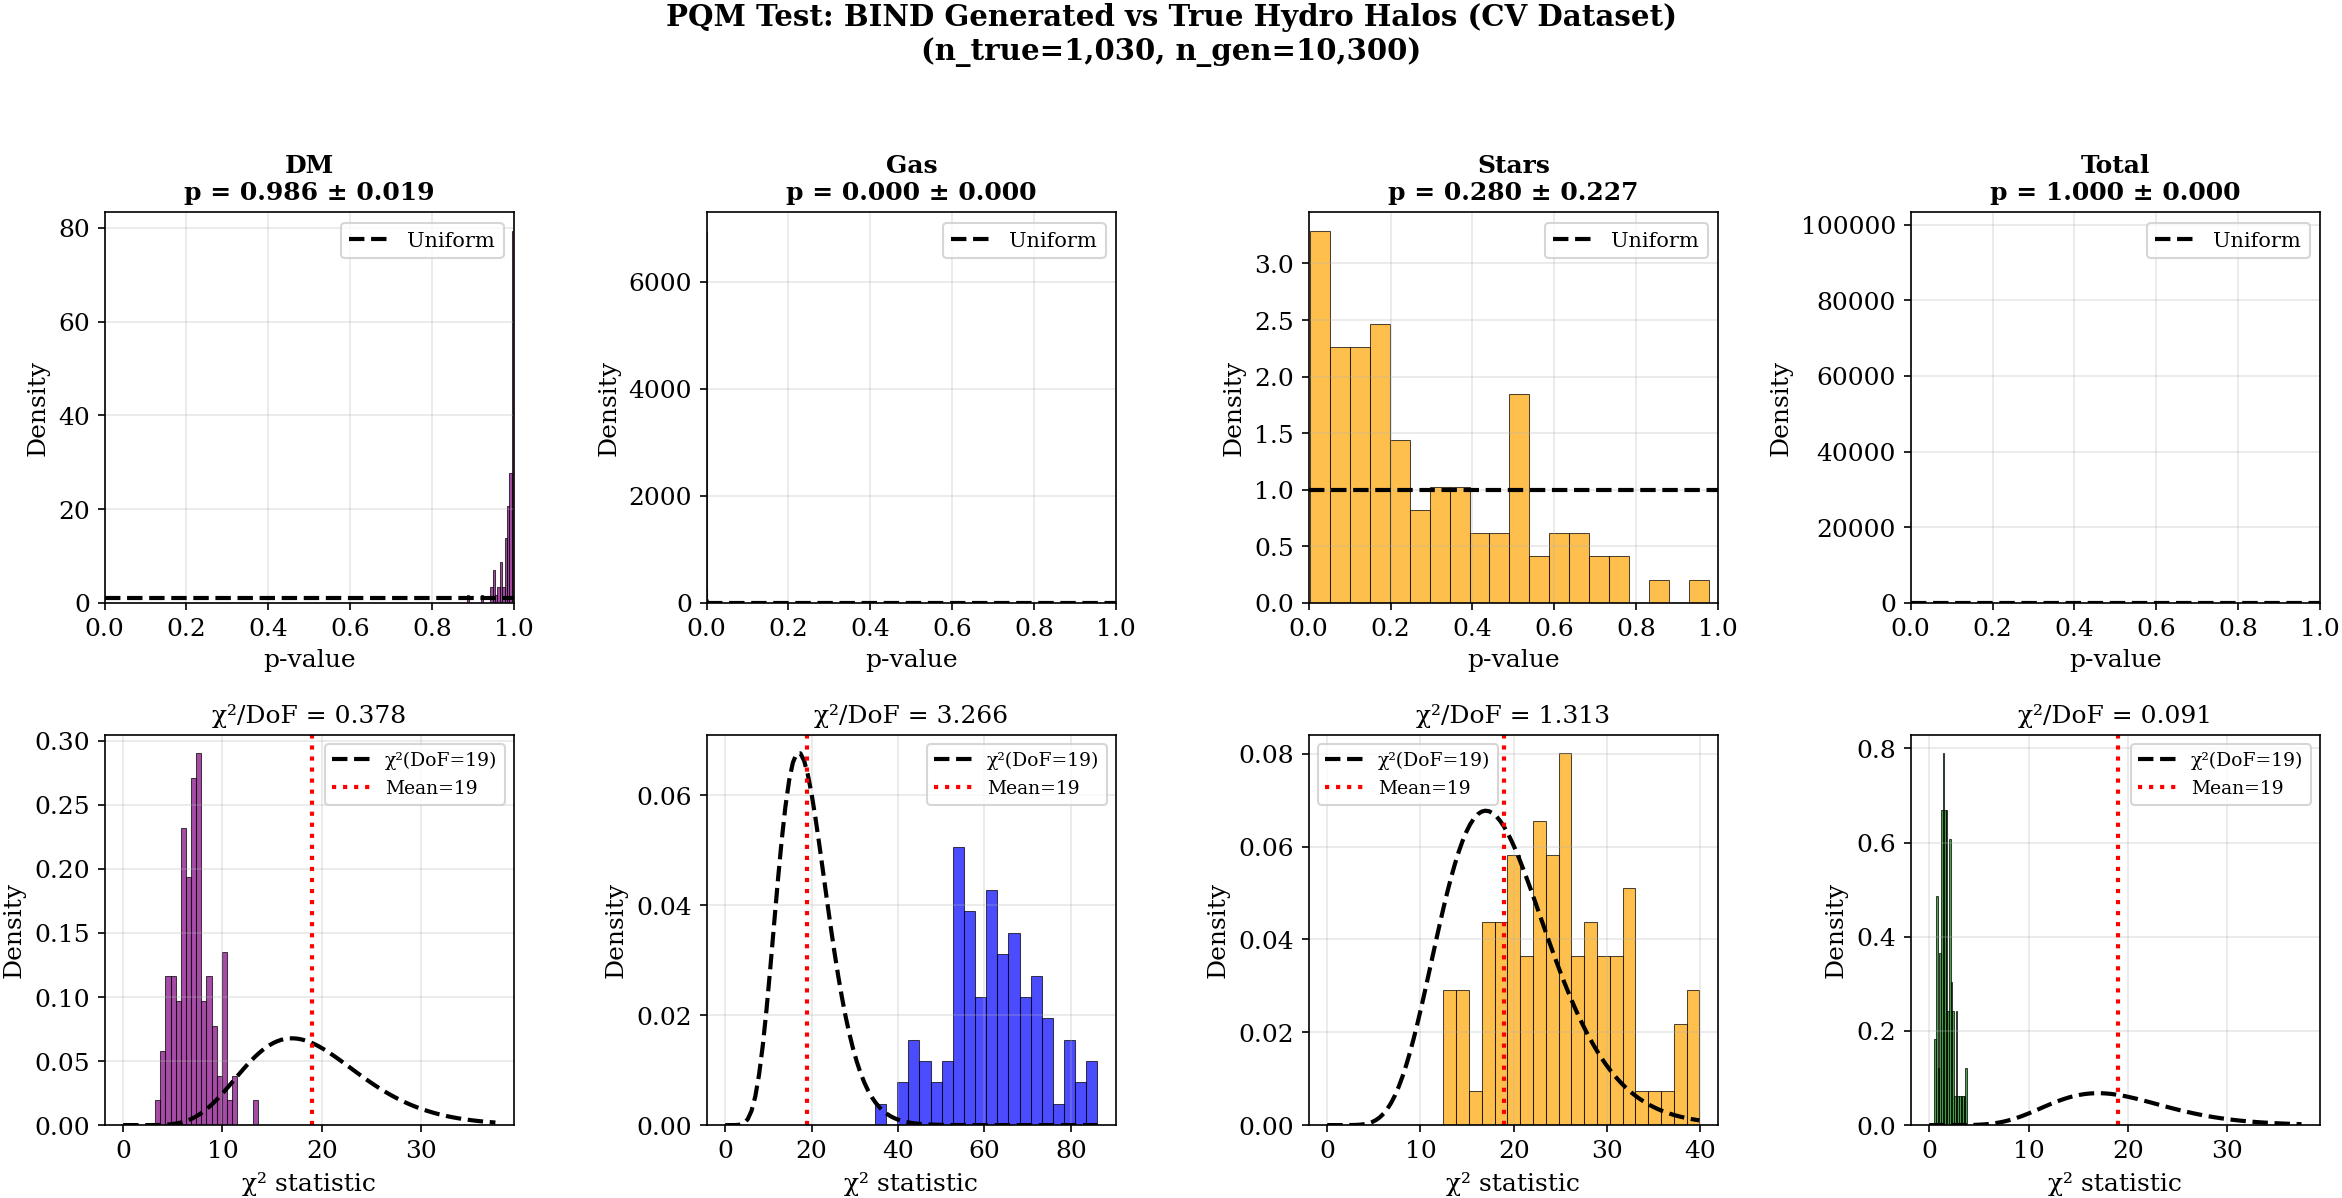

 20%|██        | 20/100 [05:56<23:45, 17.82s/it]



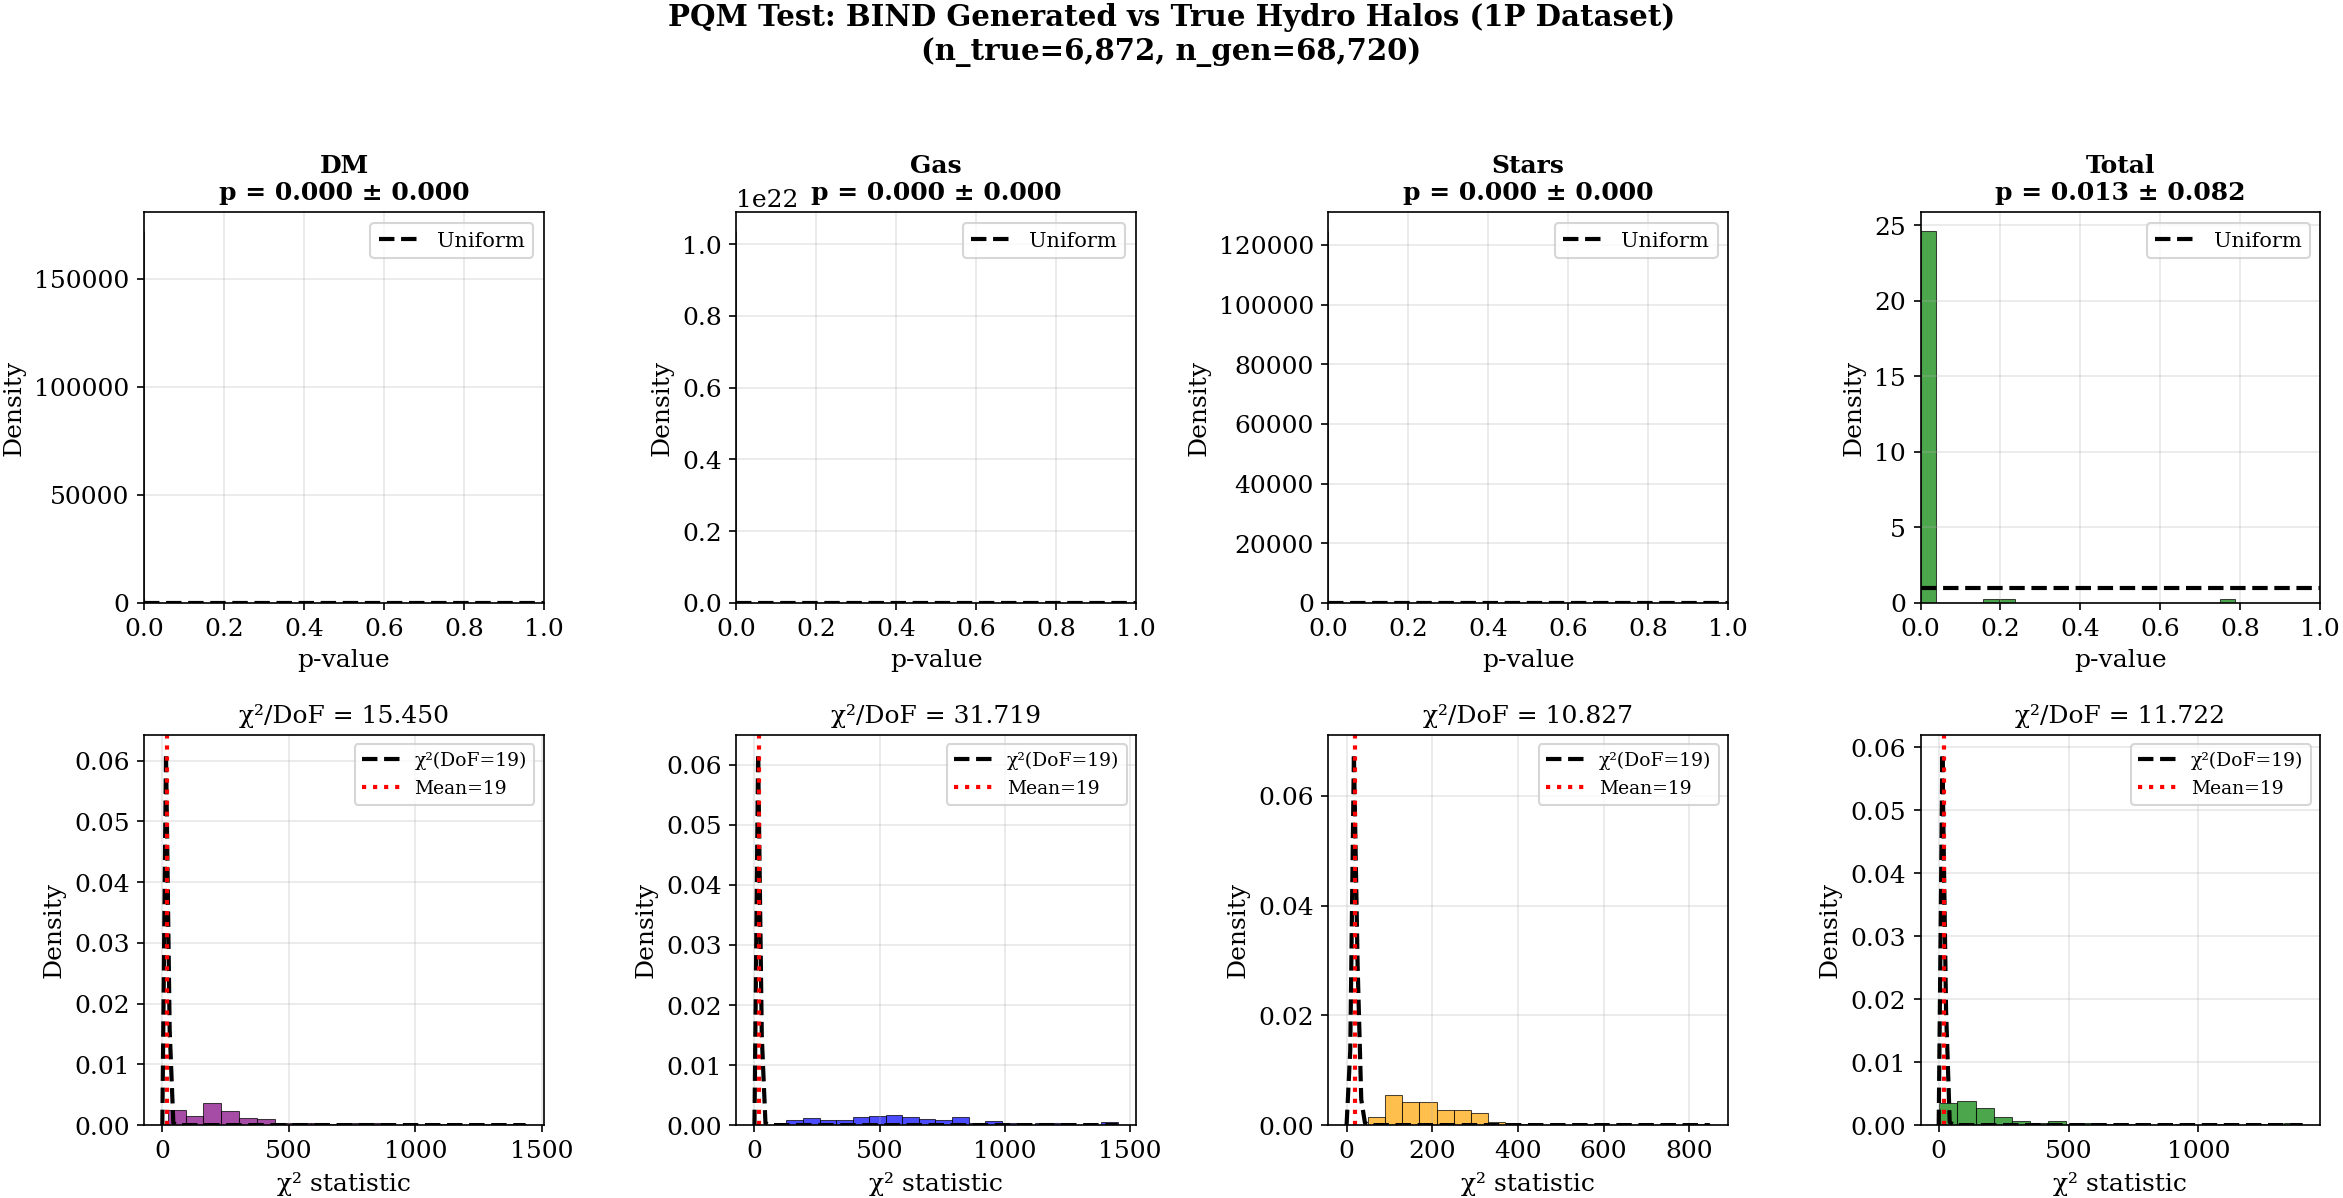

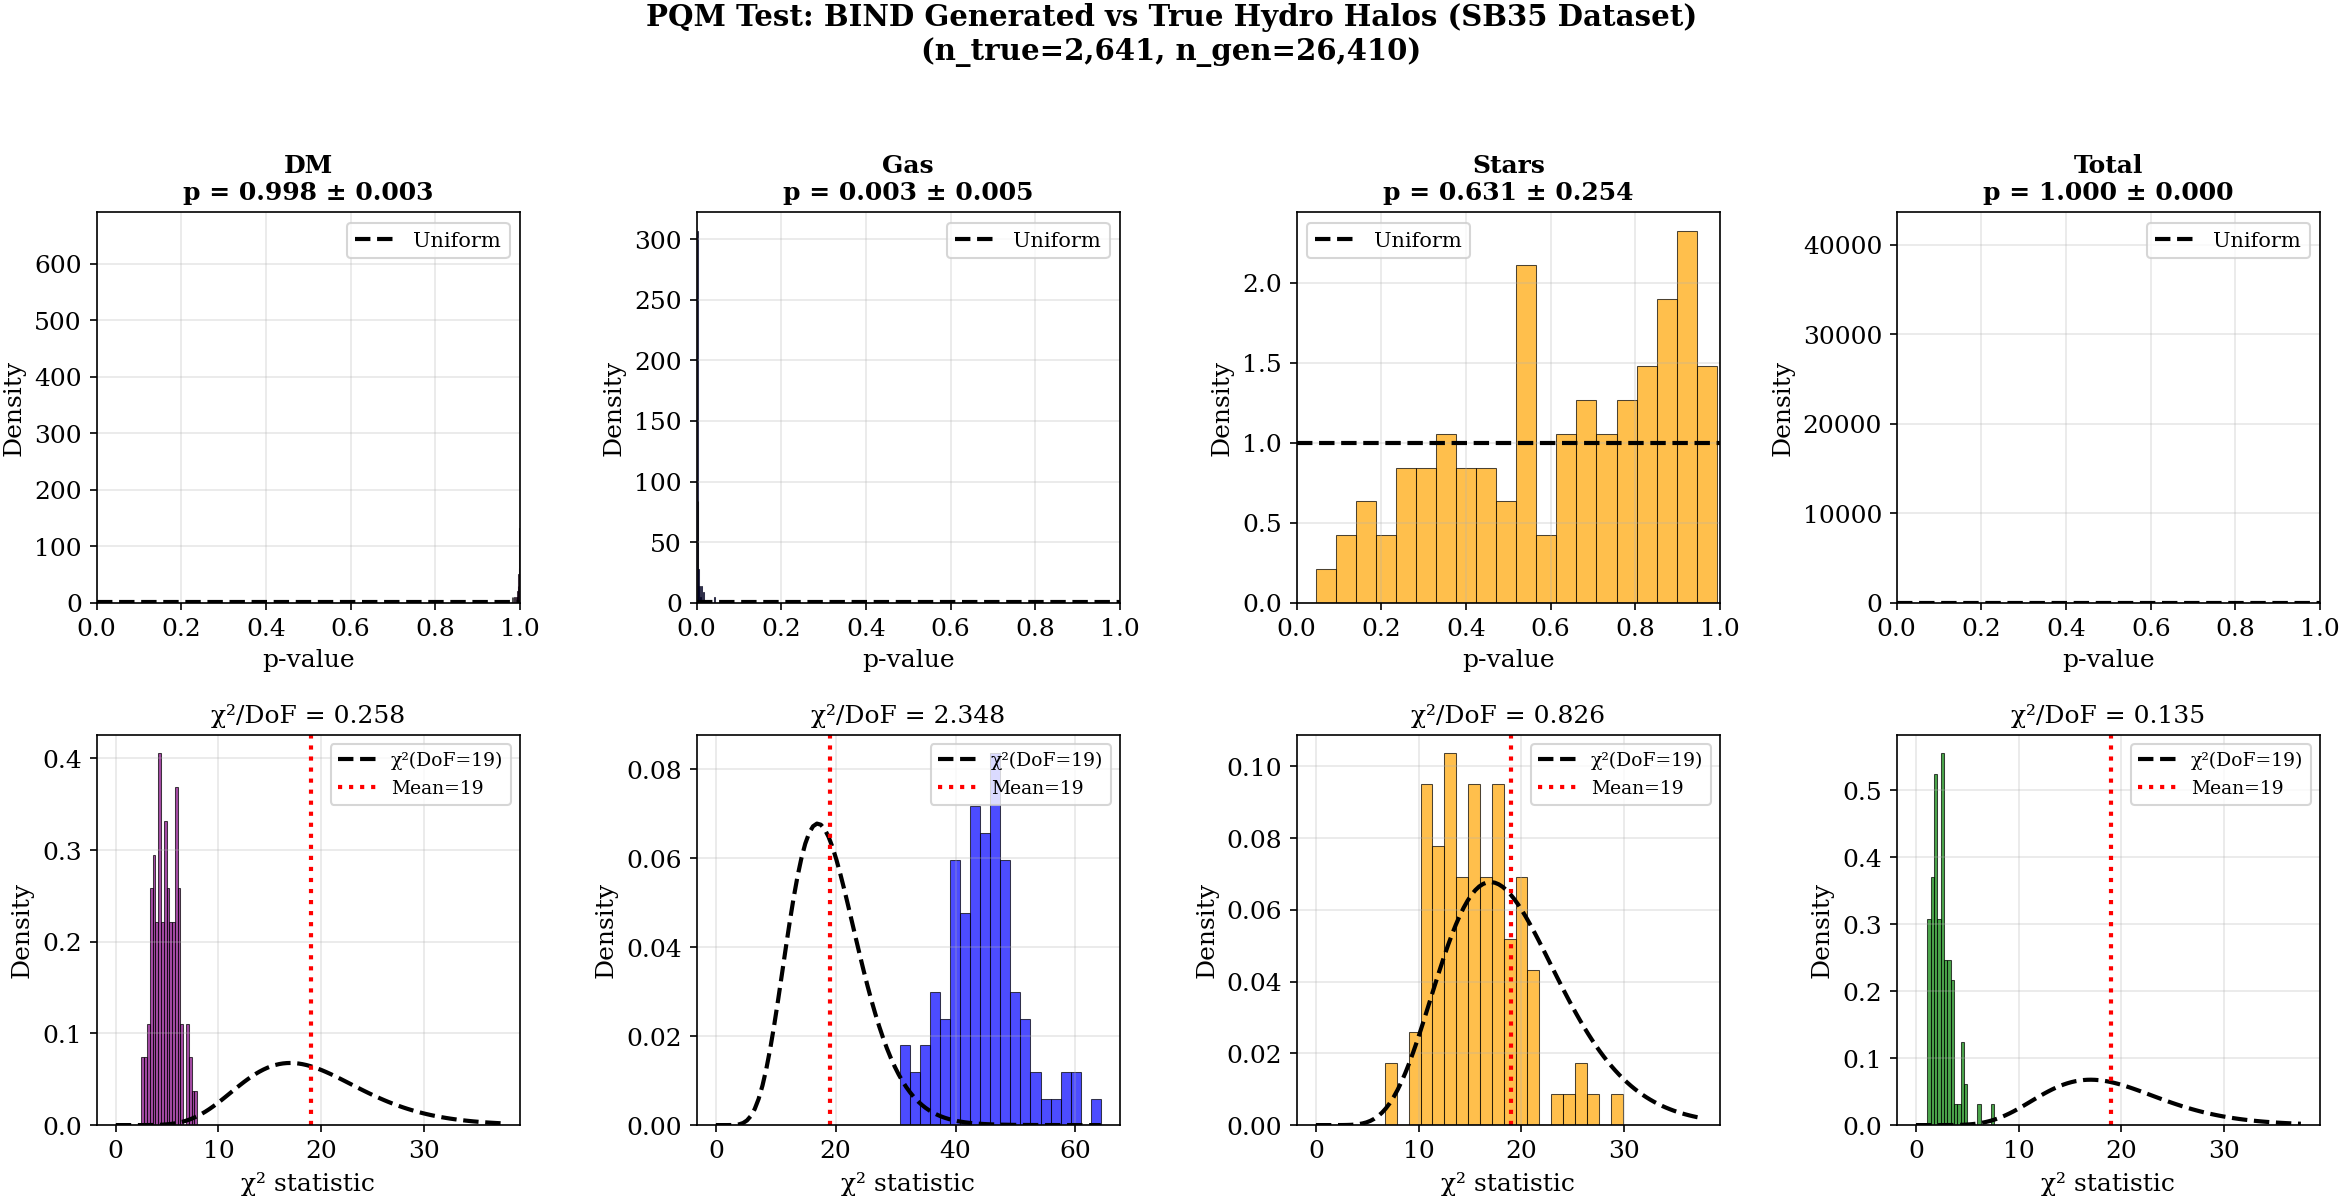

In [26]:
# Plot results for each dataset
for ds_name in ['CV', '1P', 'SB35']:
    fig = plot_pqm_results(
        pqm_results_by_dataset[ds_name],
        title_suffix=f'({ds_name} Dataset)',
        save_name=f'pqm_{ds_name.lower()}.pdf'
    )

## 8. Summary Table

In [37]:
# Create summary table
summary_data = []

# Combined results
for ch in CHANNEL_NAMES_PQM:
    r = pqm_results_combined[ch]
    summary_data.append({
        'Dataset': 'Combined',
        'Channel': ch,
        'n_true': r['n_true'],
        'n_gen': r['n_gen'],
        'p-value': f"{r['pvalue_mean']:.3f} ± {r['pvalue_std']:.3f}",
        'χ²/DoF': f"{r['chi2_mean']/r['dof']:.3f}",
        'Pass': '✓' if r['pvalue_mean'] > 0.05 else '✗'
    })

# Individual dataset results
for ds_name in ['CV', '1P', 'SB35']:
    for ch in CHANNEL_NAMES_PQM:
        r = pqm_results_by_dataset[ds_name][ch]
        summary_data.append({
            'Dataset': ds_name,
            'Channel': ch,
            'n_true': r['n_true'],
            'n_gen': r['n_gen'],
            'p-value': f"{r['pvalue_mean']:.3f} ± {r['pvalue_std']:.3f}",
            'χ²/DoF': f"{r['chi2_mean']/r['dof']:.3f}",
            'Pass': '✓' if r['pvalue_mean'] > 0.05 else '✗'
        })

summary_df = pd.DataFrame(summary_data)
print("\nPQM TEST SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))


PQM TEST SUMMARY
 Dataset Channel  n_true  n_gen       p-value χ²/DoF Pass
Combined      DM   10543 105430 0.000 ± 0.000 13.893    ✗
Combined     Gas   10543 105430 0.000 ± 0.000 14.965    ✗
Combined   Stars   10543 105430 0.000 ± 0.000  8.987    ✗
Combined   Total   10543 105430 0.000 ± 0.000 13.598    ✗
      CV      DM    1030  10300 1.000 ± 0.000  0.284    ✓
      CV     Gas    1030  10300 0.348 ± 0.212  1.001    ✓
      CV   Stars    1030  10300 0.854 ± 0.181  0.724    ✓
      CV   Total    1030  10300 1.000 ± 0.000  0.211    ✓
      1P      DM    6872  68720 0.000 ± 0.000    nan    ✗
      1P     Gas    6872  68720 0.000 ± 0.000    nan    ✗
      1P   Stars    6872  68720 0.000 ± 0.000 16.160    ✗
      1P   Total    6872  68720 0.000 ± 0.000    nan    ✗
    SB35      DM    2641  26410 1.000 ± 0.000  0.315    ✓
    SB35     Gas    2641  26410 0.865 ± 0.137  0.796    ✓
    SB35   Stars    2641  26410 0.811 ± 0.185  0.846    ✓
    SB35   Total    2641  26410 1.000 ± 0.000  0.197  

In [ ]:
# Save summary to CSV
summary_df.to_csv('paper_plots/pqm_summary.csv', index=False)
print("Summary saved to paper_plots/pqm_summary.csv")

## 9. Interpretation

### Key Points:

1. **p-value interpretation**:
   - Under the null hypothesis (same distribution), p-values should be uniformly distributed U(0,1)
   - Expected mean: 0.5, expected std: ~0.29
   - If mean p-value >> 0.5, this could indicate sample overlap/memorization
   - If mean p-value << 0.05, distributions are detectably different

2. **χ²/DoF interpretation**:
   - χ²/DoF ≈ 1.0 indicates same distribution
   - χ²/DoF >> 1.0 indicates out-of-distribution samples
   - χ²/DoF << 1.0 could indicate memorization/duplication

3. **Channel-specific considerations**:
   - **DM**: Should match well (primary input)
   - **Gas**: More challenging due to baryonic physics
   - **Stars**: Most challenging due to sparse distribution
   - **Total**: Integrated measure across all components

In [ ]:
# Final interpretation
print("\n" + "="*60)
print("FINAL INTERPRETATION")
print("="*60)

for ch in CHANNEL_NAMES_PQM:
    r = pqm_results_combined[ch]
    
    if r['pvalue_mean'] > 0.05:
        conclusion = "PASS - Cannot reject null hypothesis (same distribution)"
    else:
        conclusion = "FAIL - Reject null hypothesis (different distributions)"
    
    chi2_ratio = r['chi2_mean'] / r['dof']
    if 0.8 < chi2_ratio < 1.2:
        chi2_interp = "χ² consistent with expected"
    elif chi2_ratio > 1.2:
        chi2_interp = "χ² elevated (possible distribution mismatch)"
    else:
        chi2_interp = "χ² low (possible memorization)"
    
    print(f"\n{ch}:")
    print(f"  {conclusion}")
    print(f"  {chi2_interp}")